In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import itertools
from tqdm import tqdm
import random
from IPython.display import display

import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from tools.get_describe_record import get_describe_record

In [11]:
#featuresA = [f"X{i}" for i in range(1, 84)]
#featuresB = [f"X{i}" for i in range(1, 84)]

#best_comb: (('X15', 'X30', 'X43', 'X68'), ('X2', 'X24', 'X33', 'X37')) 	 RMSE (ALL): 44.561
featuresA = ['X15', 'X30', 'X43', 'X68']
featuresB = ['X2', 'X24', 'X33', 'X37']

comb_A = itertools.combinations(featuresA, 4)
comb_B = itertools.combinations(featuresB, 4)

comb_AB = list(itertools.product(comb_A, comb_B))
random.shuffle(comb_AB)

best_rmse = 100
rmse_sp = 100
rmse_no = 100
rmse_all = 100

best_rmse_sp = 100
best_rmse_no = 100

best_comb = None

# 異常スパイク検出用
batch_describe_df = pd.read_csv("../data/processed/batch_describe_df.csv")
test_batch = batch_describe_df.iloc[75:]


In [12]:

# 異常スパイク検知モデルと閾値スコアの読み込み
with open("../data/model/spike_detection_IFmodel.pkl", "rb") as f:
    spike_detection_model = pickle.load(f)
with open("../data/score/IF_train_score.pkl", "rb") as f:
    spike_detection_score = pickle.load(f)
thr = np.quantile(spike_detection_score, 0.90)

score_test  = -spike_detection_model.score_samples(test_batch)
pred_iso = (score_test >= thr).astype(int)
spike_batches = test_batch.index[pred_iso == 1].tolist()
normal_batches = test_batch.index[pred_iso == 0].tolist()
print(f"spike_batches: {spike_batches}")
print(f"normal_batches: {normal_batches}")


# 学習用データ
tagged_data = pd.read_csv("../data/processed/processe_tagged_anormaly.csv")
anomaly_df = tagged_data[tagged_data["is_anomaly"] == 1]
normal_df = tagged_data[tagged_data["is_anomaly"] == 0]
#display(normal_df)
anomaly_train_df = anomaly_df[anomaly_df["batch_id"] < 75]
nomaly_train_df = normal_df[normal_df["batch_id"] < 75]
display(nomaly_train_df)

# テスト用データ
test_df = pd.read_csv("../data/processed/processe_tagged_anormaly.csv")
anomaly_test_df = test_df[test_df["batch_id"].isin(spike_batches)]
normaly_test_df  = test_df[test_df["batch_id"].isin(normal_batches)]
test_df_original = test_df[test_df["batch_id"] >=75]

spike_batches: [84, 89, 90, 92, 93, 94, 95]
normal_batches: [75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 91, 96, 97, 98, 99]


,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X77,X78,X79,X80,X81,X82,X83,batch_id,batch_OV_std,is_anomaly
75,2016-09-05 07:02:00,2016-10-10 16:10:00,232.76840,23.12,2.79,982.97,0.89,0.16,0.08,419.87,...,0.18,0.0,5.9,0.00,0.03,0.19,0.03,2,18.030431,0
76,2016-09-05 07:02:00,2016-10-10 21:53:00,203.99410,23.12,2.79,982.97,0.89,0.16,0.08,419.87,...,0.18,0.0,5.9,0.00,0.03,0.19,0.03,2,18.030431,0
77,2016-09-05 07:02:00,2016-10-11 02:24:00,214.65380,23.12,2.79,982.97,0.89,0.16,0.08,419.87,...,0.18,0.0,5.9,0.00,0.03,0.19,0.03,2,18.030431,0
78,2016-09-05 07:02:00,2016-10-11 07:10:00,189.10500,23.12,2.79,982.97,0.89,0.16,0.08,419.87,...,0.18,0.0,5.9,0.00,0.03,0.19,0.03,2,18.030431,0
79,2016-09-05 07:02:00,2016-10-11 11:16:00,198.91220,23.12,2.79,982.97,0.89,0.16,0.08,419.87,...,0.18,0.0,5.9,0.00,0.03,0.19,0.03,2,18.030431,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,2016-11-27 02:23:00,2017-01-13 00:47:00,82.84555,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.20,0.0,2.7,0.02,0.01,0.25,0.04,74,17.281147,0
1762,2016-11-27 02:23:00,2017-01-13 02:04:00,78.26471,24.35,4.92,635.52,0.64,0.14,0.09,78.09,...,0.20,0.0,2.7,0.02,0.01,0.25,0.04,74,17.281147,0
1763,2016-11-27 02:23:00,2017-01-13 04:58:00,101.99680,24.35,4.92,635.52,0.64,0.14,0.09,78.09,...,0.20,0.0,2.7,0.02,0.01,0.25,0.04,74,17.281147,0
1764,2016-11-27 02:23:00,2017-01-13 06:08:00,90.90938,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.20,0.0,2.7,0.02,0.01,0.25,0.04,74,17.281147,0


## 特徴量エンジニアリング

In [13]:
# 特徴量エンジニアリング
def feature_engineering1(
    df,
    SENSOR_COLS,
    LAGS,
    WINS
    ):
    base = df[SENSOR_COLS].copy()
    feats = {}  # ★ここに全部貯める

    for c in SENSOR_COLS:
        s = df[c]

        #std
        feats[f"{c}_std5"] = s.rolling(5, min_periods=1).std()
        feats[f"{c}_std10"] = s.rolling(10, min_periods=1).std()
        
        # lag
        for l in LAGS:
            feats[f"{c}_lag{l}"] = s.shift(l)

        # diff / pct
        feats[f"{c}_diff1"] = s.diff(1)
        feats[f"{c}_diff2"] = s.diff(2)
        feats[f"{c}_diff3"] = s.diff(3)
        feats[f"{c}_pct1"]  = s.pct_change(1).replace([np.inf, -np.inf], np.nan)

        # rolling
        for w in WINS:
            r = s.rolling(w, min_periods=1)
            rmean = r.mean()
            rstd  = r.std()
            feats[f"{c}_rmean{w}"] = rmean
            feats[f"{c}_rstd{w}"]  = rstd
            feats[f"{c}_rmax{w}"]  = r.max()
            feats[f"{c}_rmin{w}"]  = r.min()
            feats[f"{c}_z{w}"]     = (s - rmean) / (rstd + 1e-9)
            feats[f"{c}_dev{w}"]   = s - rmean
        
        feats[f"{c}_energy"] = (
            feats[f"{c}_rstd20"] * feats[f"{c}_rmax20"]
        )

        feats[f"{c}_jump"] = s - s.shift(5)

    feat_df = pd.concat([base, pd.DataFrame(feats, index=df.index)], axis=1)
    feat_df = feat_df.ffill().bfill().fillna(0)
    return feat_df


def df_set_datetime(df, col_names):
    df = df.copy()
    for col in col_names:
        df[col] = pd.to_datetime(df[col])
    return df

def get_elapsed_day(df, base_time=None, col="process_end_time"):
    df = df.copy()
    if base_time is None:
        base_time = df[col].min()
    df["elapsed_day"] = (df[col] - base_time).dt.total_seconds() / (3600 * 24)
    return df

def add_time_features(df, time_col="process_end_time"):
    """周期性（曜日・時間帯）を入れたいとき用。不要なら呼ばなくてOK"""
    df = df.copy()
    t = df[time_col]
    df["dow"] = t.dt.dayofweek              # 0=Mon
    df["hour"] = t.dt.hour

    # 周期は sin/cos にすると学習しやすい
    df["dow_sin"]  = np.sin(2*np.pi*df["dow"]/7)
    df["dow_cos"]  = np.cos(2*np.pi*df["dow"]/7)
    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
    return df

def add_duration_features(df, start_col="process_end_time", end_col="final_mes_time"):
    """工程時間（測定完了までの所要）"""
    df = df.copy()
    dur = (df[end_col] - df[start_col]).dt.total_seconds()
    df["duration_sec"] = dur
    df["duration_log1p"] = np.log1p(np.clip(dur, 0, None))
    return df

def add_ov_features(
    df,
    target="OV",
    lags=(1, 2, 3, 10),
    wins=(3, 5, 10, 20),
    ema_spans=(2, 5, 10, 20)
):
    """
    重要：リーク防止のため “すべて1ステップ前まで” を使う
    → lagはshift(l)、rolling/emaはshift(1)
    """
    df = df.copy()
    y = df[target]

    # lag
    for l in lags:
        df[f"{target}_lag{l}"] = y.shift(l)

    # diff（1つ前までしか見ない）
    df[f"{target}_diff1"] = y.diff(1).shift(1)
    df[f"{target}_diff2"] = y.diff(2).shift(1)

    # rolling stats（1つ前まで）
    for w in wins:
        r = y.rolling(w, min_periods=1)
        mean = r.mean().shift(1)
        std  = r.std().shift(1)
        mx   = r.max().shift(1)
        mn   = r.min().shift(1)

        df[f"{target}_roll_mean{w}"] = mean
        df[f"{target}_roll_std{w}"]  = std
        df[f"{target}_roll_max{w}"]  = mx
        df[f"{target}_roll_min{w}"]  = mn
        df[f"{target}_dev{w}"]       = y.shift(1) - mean
        df[f"{target}_z{w}"]         = (y.shift(1) - mean) / (std + 1e-9)

        # 窓内レンジ（スパイク気配）
        df[f"{target}_range{w}"]     = mx - mn

    # EMA（指数移動平均、反応が速い）
    for s in ema_spans:
        ema = y.ewm(span=s, adjust=False).mean().shift(1)
        df[f"{target}_ema{s}"] = ema
        df[f"{target}_ema_dev{s}"] = y.shift(1) - ema

    # “短期荒れ / 長期荒れ” 比（スパイク前兆に刺さりやすい）
    if 5 in wins and 20 in wins:
        df[f"{target}_std_ratio_5_20"] = df[f"{target}_roll_std5"] / (df[f"{target}_roll_std20"] + 1e-9)

    return df

def add_ov_batch_features(df, target="OV", batch_col="batch_id", wins=(3,5,10,20)):
    df = df.copy()
    df = df.sort_values(["process_end_time", "final_mes_time"]).reset_index(drop=True)

    g = df.groupby(batch_col, sort=False)[target]

    # バッチ内の「何番目か」
    df["pos_in_batch"] = g.cumcount()  # 0,1,2,...

    # バッチ内の過去だけで作る累積統計（expanding）※ shift(1) が肝
    past = g.shift(1)

    df[f"{target}_batch_exp_mean"] = past.groupby(df[batch_col]).expanding().mean().reset_index(level=0, drop=True)
    df[f"{target}_batch_exp_std"]  = past.groupby(df[batch_col]).expanding().std().reset_index(level=0, drop=True)
    df[f"{target}_batch_exp_max"]  = past.groupby(df[batch_col]).expanding().max().reset_index(level=0, drop=True)
    df[f"{target}_batch_exp_min"]  = past.groupby(df[batch_col]).expanding().min().reset_index(level=0, drop=True)

    # バッチ内rolling（直近w点）も過去だけで
    for w in wins:
        df[f"{target}_batch_roll_mean{w}"] = g.shift(1).rolling(w, min_periods=1).mean()
        df[f"{target}_batch_roll_std{w}"]  = g.shift(1).rolling(w, min_periods=1).std()
        df[f"{target}_batch_roll_max{w}"]  = g.shift(1).rolling(w, min_periods=1).max()
        df[f"{target}_batch_roll_min{w}"]  = g.shift(1).rolling(w, min_periods=1).min()

    # 欠損は ffill せず、0埋め or 明示的に埋め（初期は過去がないので）
    df = df.fillna(0)
    return df

def feature_engineering2(
    df,
    normal_features,
    target="OV",
    lags=(1,2,3,5,10),
    wins=(3,5,10,20),
    ema_spans=(2,5,10,20),
    use_time_features=False
):
    df = df.copy()
    df = df_set_datetime(df, ["process_end_time", "final_mes_time"])
    df = df.sort_values(["process_end_time", "final_mes_time"]).reset_index(drop=True)

    df = get_elapsed_day(df, col="process_end_time")
    df = add_duration_features(df, "process_end_time", "final_mes_time")
    if use_time_features:
        df = add_time_features(df, "process_end_time")

    # 既存：OVの過去特徴量（リークなし）
    df = add_ov_features(df, target=target, lags=lags, wins=wins, ema_spans=ema_spans)

    # 追加：batch内の過去統計（リークなし）
    if "batch_id" in df.columns:
        df = add_ov_batch_features(df, target=target, batch_col="batch_id", wins=wins)

    # 欠損処理：時系列は基本ffillのみ（bfillは未来リークの可能性）
    df = df.ffill().fillna(0)

    # 必要列だけ
    df = df.drop(columns=[c for c in df.columns if c not in normal_features])
    return df

## 変数重み付け, fit, モデル評価

In [14]:
def make_spike_weights(y_raw, q_pct=90, power=3):
    q = np.percentile(y_raw, q_pct)
    w = np.ones_like(y_raw, dtype=float)
    hi = y_raw >= q
    w[hi] = 1 + ((y_raw[hi] / (q + 1e-9)) ** power)
    w = np.clip(w, 1.0, np.percentile(w, 95))
    return w


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def fit_predict_spike(model, X_train, y_train_raw, X_test, sample_weight=None):
    """log1p学習 → expm1復元（RMSE評価は呼び出し側）"""
    y_train = np.log1p(y_train_raw)

    m = clone(model)
    # sample_weight が使えないモデルもあるので吸収
    try:
        m.fit(X_train, y_train, sample_weight=sample_weight)
    except TypeError:
        m.fit(X_train, y_train)

    pred = np.expm1(m.predict(X_test))
    return pred


def fit_predict_normal(model, X_train, y_train, X_test):
    """フラット側は元スケールのまま（必要ならここもlogに統一してOK）"""
    m = clone(model)
    m.fit(X_train, y_train)
    return m.predict(X_test)


def spike_model_candidates(random_state=42):
    """スパイク側：sample_weight対応があると嬉しいモデル中心"""
    models = {
        "RF_1500_d18": RandomForestRegressor(
            n_estimators=1500, max_depth=18, min_samples_leaf=1,
            random_state=random_state, n_jobs=-1
        ),
        "ET_2000": ExtraTreesRegressor(
            n_estimators=2000, max_depth=None, min_samples_leaf=1,
            random_state=random_state, n_jobs=-1
        ),
        "GBR_Huber": GradientBoostingRegressor(
            loss="huber", n_estimators=600, learning_rate=0.05,
            max_depth=3, random_state=random_state
        ),
    }
    models["LGBM_spike"] = LGBMRegressor(
        objective="regression",
        n_estimators=4000,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1,
        verbose=-1
    )
    return models


def normal_model_candidates(random_state=42):
    """フラット側：現状LGBM+Scalerを候補化（RF/ETも比較可能）"""
    models = {}

    # LightGBM（現状のパイプラインを候補1に）
    models["Pipe_Scaler+LGBM"] = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LGBMRegressor(
            objective="regression",
            metric="rmse",
            verbose=-1,
            random_state=random_state,
            n_estimators=2000,
            learning_rate=0.03
        ))
    ])
    # 追加候補
    models["Pipe_Scaler+RF"] = Pipeline([
        ("scaler", StandardScaler()),
        ("model", RandomForestRegressor(
            n_estimators=1200, max_depth=None, random_state=random_state, n_jobs=-1
        ))
    ])
    models["Pipe_Scaler+ET"] = Pipeline([
        ("scaler", StandardScaler()),
        ("model", ExtraTreesRegressor(
            n_estimators=1500, max_depth=None, random_state=random_state, n_jobs=-1
        ))
    ])
    return models

In [15]:
for (comb_A, comb_B) in comb_AB:
    # スパイクモデルの学習
    SENSOR_COLS = list(comb_A)
    LAGS = [1, 2, 3, 5, 10, 20]
    WINS = [3, 5, 10, 20]

    train_feature_df = feature_engineering1(anomaly_train_df, SENSOR_COLS=SENSOR_COLS, LAGS=LAGS, WINS=WINS)
    #test_feature_df = feature_engineering1(anomaly_test_df, SENSOR_COLS=SENSOR_COLS, LAGS=LAGS, WINS=WINS)

    # スパイク部分の学習
    X_sp = train_feature_df
    y_sp = np.log1p(anomaly_train_df["OV"].values)

    # 高OVを重くする（まずは80%点を基準）
    q = np.percentile(anomaly_train_df["OV"].values, 90)  # “頂点”の境界
    w = np.ones_like(anomaly_train_df["OV"].values, dtype=float)
    w[anomaly_train_df["OV"].values >= q] = 1 + ((anomaly_train_df["OV"].values[anomaly_train_df["OV"].values >= q] / (q+1e-9))**3)
    w = np.clip(w, 1.0, np.percentile(w, 95))

    spike_predict_model = RandomForestRegressor(
        n_estimators=1500,
        max_depth=18,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    spike_predict_model.fit(X_sp, y_sp, sample_weight=w)

    test_feature_df = feature_engineering1(anomaly_test_df, SENSOR_COLS=SENSOR_COLS, LAGS=LAGS, WINS=WINS)
    spiked_pred = spike_predict_model.predict(test_feature_df)
    spiked_pred = np.expm1(spiked_pred)
    spiked_pred_series = pd.Series(spiked_pred, index=anomaly_test_df.index)
    rmse_sp = np.sqrt(mean_squared_error(anomaly_test_df["OV"], spiked_pred))
    #print(spiked_pred)

    # フラット部分の学習
    normal_features = [
        # 時間系
        "elapsed_day", "duration_sec", "duration_log1p",

        # OVの過去特徴
        "OV_lag1","OV_lag2","OV_lag5",
        "OV_diff1","OV_roll_mean5","OV_roll_std5","OV_z5",
        "OV_ema5","OV_ema_dev5",
        "OV_std_ratio_5_20",

        # バッチ内過去統計（追加）
        "pos_in_batch",
        "OV_batch_exp_mean","OV_batch_exp_std","OV_batch_exp_max","OV_batch_exp_min",
        "OV_batch_roll_mean5","OV_batch_roll_std5",

        # 使うセンサ（comb_Bなど）
        *list(comb_B),

        # target（学習dfには含める）
        "OV"
    ]
    train_df= feature_engineering2(nomaly_train_df, normal_features)
    test_df= feature_engineering2(normaly_test_df, normal_features)

    pipeline = Pipeline([
        #("scaler", StandardScaler()),
        ("scaler", StandardScaler()),
        ("model", LGBMRegressor(
            objective="regression",
            metric="rmse",
            verbose=-1,
            random_state=42
        ))
    ])
    train_X = train_df[normal_features].drop(columns=["OV"])
    pipeline.fit(train_X, train_df["OV"])

    test_X = test_df[normal_features].drop(columns=["OV"])
    normal_pred = pipeline.predict(test_X)
    rmse_no = np.sqrt(mean_squared_error(normaly_test_df["OV"], normal_pred))
    normal_pred_series = pd.Series(normal_pred, index=normaly_test_df.index)
    df_eval = pd.concat([test_df_original["OV"].rename("y_true"), spiked_pred_series.rename("y_pred")], axis=1)
    df_eval["y_pred"] = df_eval["y_pred"].fillna((normal_pred_series))
    rmse_all = np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_pred"]))
    
    print(f"COMB:{comb_A, comb_B} \t RMSE (ALL): {rmse_all:.3f} \t RMSE (SP): {rmse_sp:.3f} \t RMSE (NO): {rmse_no:.3f} \t RMSE BEST: {best_rmse:.3f}\t{best_rmse_sp:.3f}\t{best_rmse_no:.3f}")
    if rmse_sp < best_rmse_sp:
        best_rmse_sp = rmse_sp
        best_comb_sp = (comb_A, comb_B)
    if rmse_no < best_rmse_no:
        best_rmse_no = rmse_no
        best_comb_no = (comb_A, comb_B)
    if rmse_all < best_rmse:
        print("BEST MODEL FOUND") 
        best_rmse = rmse_all
        best_comb = (comb_A, comb_B)

print(f"best_comb: {best_comb} \t RMSE (ALL): {best_rmse:.3f}")
print(f"best_comb_sp: {best_comb_sp} \t RMSE (SP): {best_rmse_sp:.3f}")
print(f"best_comb_no: {best_comb_no} \t RMSE (NO): {best_rmse_no:.3f}")

COMB:(('X15', 'X30', 'X43', 'X68'), ('X2', 'X24', 'X33', 'X37')) 	 RMSE (ALL): 44.561 	 RMSE (SP): 72.299 	 RMSE (NO): 24.947 	 RMSE BEST: 100.000	100.000	100.000
BEST MODEL FOUND
best_comb: (('X15', 'X30', 'X43', 'X68'), ('X2', 'X24', 'X33', 'X37')) 	 RMSE (ALL): 44.561
best_comb_sp: (('X15', 'X30', 'X43', 'X68'), ('X2', 'X24', 'X33', 'X37')) 	 RMSE (SP): 72.299
best_comb_no: (('X15', 'X30', 'X43', 'X68'), ('X2', 'X24', 'X33', 'X37')) 	 RMSE (NO): 24.947


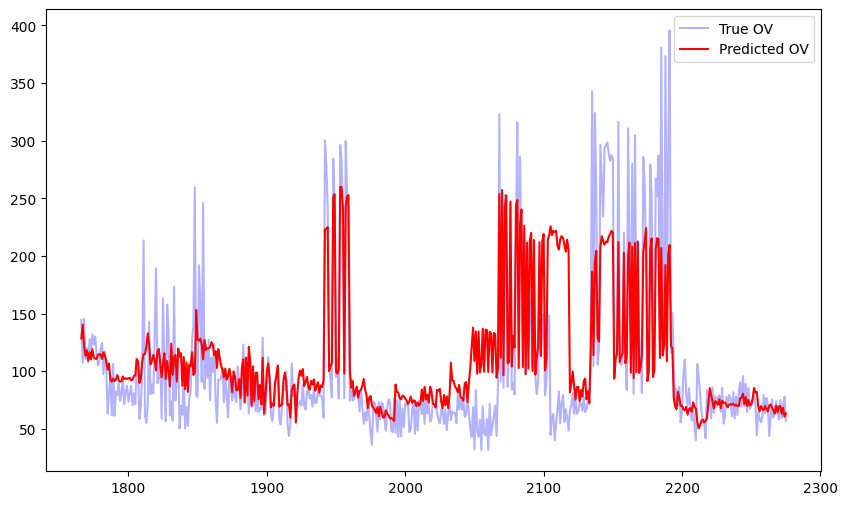

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(
    df_eval["y_true"],
    label="True OV",
    color="blue",
    alpha=0.3
)
plt.plot(
    df_eval["y_pred"],
    label="Predicted OV",
    color="red",
    alpha=1
)
plt.legend()
plt.show()